In [10]:
!pip install gymnasium

import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# Define model
class QNetwork(nn.Module):

    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """ state_shape (int): Dimension of each state
            h1_nodes (int): Number of nodes in first hidden layer
            action_space_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_shape, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes,h1_nodes)
        self.out = nn.Linear(h1_nodes, action_space_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x=self.out(x)
        return x

In [13]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen, batch_size):
        self.memory = deque([], maxlen=maxlen)
        self.batch_size = batch_size

    def append(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

In [14]:
#Define the Standard Deep QLearning Agent
class DQAgent():
        """Interacts with and learns from the environment."""

        def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, replay_memory_size=int(1e5),batch_size=64, UPDATE_EVERY=1000, LEARN_EVERY=4,GAMMA=0.99):
           """Initialize an Agent object. """

           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.LERN_EVERY = LEARN_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate
           self.batch_size = batch_size
           self.replay_memory_size = replay_memory_size


           # Q-Network
           self.local_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)
           self.target_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Replay memory
           self.memory = ReplayMemory( self.replay_memory_size,self.batch_size)

           # Initialize time step (for learn every LEARN_EVERY steps)
           self.l_step = 0

           # Initialize time step (for updating every UPDATE_EVERY steps)
           self.t_step = 0

        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          if random.random() > eps:
            action_values = self.local_dqn(self.state_to_dqn_input(state))
            return np.argmax(action_values.cpu().data.numpy())

          else:
            return random.choice(np.arange(self.action_space_size))

        def step(self, state, action, reward, next_state, done):
           # Save experience in replay memory
           self.memory.append((state, action, reward, next_state, done))

           # If enough samples are available in memory, get random subset and learn
           self.l_step = (self.l_step + 1) % self.LERN_EVERY
           if self.l_step == 0 and len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

           # Copy local network to target network every UPDATE_EVERY time steps
           self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
           if self.t_step == 0:
              self.target_dqn.load_state_dict(self.local_dqn.state_dict())

        def learn(self, experiences):
          q_target_list = []
          q_expected_list = []
          # Obtain random minibatch of tuples from ReplayMemory
          for  state, action, reward, next_state, done in experiences:
             # Convert state and next_state to tensors only if they are not already tensors

             state = self.state_to_dqn_input(state)
             next_state = self.state_to_dqn_input(next_state)
             action= torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
             reward = torch.from_numpy(np.array([reward])).float().unsqueeze(0).to(device)
             ## Compute and minimize the loss

             ### Extract next maximum estimated value from target network
             if(done):
               q_target =  reward
             else:
               q_target=  reward + self.GAMMA *self.target_dqn(next_state).max(1)[0]

             ### Calculate expected value from local network
             q_local = self.local_dqn(state).gather(1, action)

             q_target_list.append(q_target)
             q_expected_list.append(q_local)

          ### Loss calculation (we used Mean squared error)
          loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

In [15]:
#Define the DQN Agent WITHOUT Experience Replay
class DQAgentNoReplay():


        def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, UPDATE_EVERY=1000, GAMMA=0.99):


           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate


           # Q-Network
           self.local_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)
           self.target_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Initialize time step
           self.t_step = 0

        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          if random.random() > eps:
            action_values = self.local_dqn(self.state_to_dqn_input(state))
            return np.argmax(action_values.cpu().data.numpy())

          else:
            return random.choice(np.arange(self.action_space_size))

        def step(self, state, action, reward, next_state, done):
           # Learn immediately from this single experience (no replay)
           self.learn(state, action, reward, next_state, done)

           # Copy local network to target network every UPDATE_EVERY time steps
           self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
           if self.t_step == 0:
              self.target_dqn.load_state_dict(self.local_dqn.state_dict())

        def learn(self, state, action, reward, next_state, done):
          """Update value parameters from a single experience."""

          state = self.state_to_dqn_input(state)
          next_state = self.state_to_dqn_input(next_state)
          action= torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
          reward = torch.from_numpy(np.array([reward])).float().unsqueeze(0).to(device)

          ## Compute and minimize the loss

          ### Extract next maximum estimated value from target network
          if(done):
            q_target =  reward
          else:
            q_target=  reward + self.GAMMA *self.target_dqn(next_state).max(1)[0]

          ### Calculate expected value from local network
          q_local = self.local_dqn(state).gather(1, action)

          ### Loss calculation (we used Mean squared error)
          loss = F.mse_loss(q_local, q_target)
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

In [16]:
#Define the DQN Agent with CORRELATED Experiences
class DQAgentCorrelated():
        """DQN Agent that learns from correlated experiences."""

        def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, batch_size=64, UPDATE_EVERY=1000, LEARN_EVERY=4, GAMMA=0.99):
           """Initialize an Agent object. """

           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.LERN_EVERY = LEARN_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate
           self.batch_size = batch_size


           # Q-Network
           self.local_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)
           self.target_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Sequential buffer (not random sampling)
           self.experience_buffer = []

           # Initialize time step (for learn every LEARN_EVERY steps)
           self.l_step = 0

           # Initialize time step (for updating every UPDATE_EVERY steps)
           self.t_step = 0

        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          if random.random() > eps:
            action_values = self.local_dqn(self.state_to_dqn_input(state))
            return np.argmax(action_values.cpu().data.numpy())

          else:
            return random.choice(np.arange(self.action_space_size))

        def step(self, state, action, reward, next_state, done):
           # Save experience in sequential buffer
           self.experience_buffer.append((state, action, reward, next_state, done))

           # Learn from batch of correlated experiences every LEARN_EVERY steps
           self.l_step = (self.l_step + 1) % self.LERN_EVERY
           if self.l_step == 0 and len(self.experience_buffer) >= self.batch_size:
                # Take the last batch_size experiences (correlated/sequential)
                experiences = self.experience_buffer[-self.batch_size:]
                self.learn(experiences)
                # Clear buffer after learning
                self.experience_buffer = []

           # Copy local network to target network every UPDATE_EVERY time steps
           self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
           if self.t_step == 0:
              self.target_dqn.load_state_dict(self.local_dqn.state_dict())

        def learn(self, experiences):
          """Update value parameters from correlated experiences."""
          q_target_list = []
          q_expected_list = []
          # Process sequential batch of experiences
          for  state, action, reward, next_state, done in experiences:

             state = self.state_to_dqn_input(state)
             next_state = self.state_to_dqn_input(next_state)
             action= torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
             reward = torch.from_numpy(np.array([reward])).float().unsqueeze(0).to(device)
             ## Compute and minimize the loss

             ### Extract next maximum estimated value from target network
             if(done):
               q_target =  reward
             else:
               q_target=  reward + self.GAMMA *self.target_dqn(next_state).max(1)[0]

             ### Calculate expected value from local network
             q_local = self.local_dqn(state).gather(1, action)

             q_target_list.append(q_target)
             q_expected_list.append(q_local)

          ### Loss calculation (we used Mean squared error)
          loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

In [23]:
def dqn_train(agent, env, n_episodes=250, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in  tqdm(range(1, n_episodes+1)):
        state = env.reset()[0]

        score = 0
        for t in range(max_t):
            # select an action
            action = agent.act(state, eps)

            #apply the selected action
            next_state, reward, done, _,_=env.step(action)

            # store the current experience
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return scores

In [24]:
# Initialize environment
env = gym.make('CartPole-v1')
print(env.reset())
print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([-0.0125074 ,  0.00049375,  0.01123504,  0.01571991], dtype=float32), {})
State shape:  4
Number of actions:  2


In [25]:
# Train DQN Agent WITHOUT Experience Replay
print("\n" + "="*60)
print("Training DQN Agent WITHOUT Experience Replay")
print("="*60)
agent_no_replay = DQAgentNoReplay(state_shape=env.observation_space.shape[0],
                                   action_space_size=env.action_space.n,
                                   seed=0)
scores_no_replay = dqn_train(agent_no_replay, env)
torch.save(agent_no_replay.local_dqn.state_dict(), 'checkpoint_no_replay.pth')


Training DQN Agent WITHOUT Experience Replay


 22%|██▏       | 54/250 [00:02<00:07, 25.64it/s]

Episode 50	Average Score: 20.68


 40%|████      | 100/250 [00:04<00:07, 20.77it/s]

Episode 100	Average Score: 20.44


 60%|█████▉    | 149/250 [00:07<00:04, 21.91it/s]

Episode 150	Average Score: 21.86


 82%|████████▏ | 204/250 [00:10<00:02, 22.68it/s]

Episode 200	Average Score: 24.08


100%|██████████| 250/250 [00:13<00:00, 18.95it/s]

Episode 250	Average Score: 24.65


In [26]:
# Train DQN Agent with CORRELATED Experiences
print("\n" + "="*60)
print("Training DQN Agent with Correlated Experiences")
print("="*60)
agent_correlated = DQAgentCorrelated(state_shape=env.observation_space.shape[0],
                                      action_space_size=env.action_space.n,
                                      seed=0)
scores_correlated = dqn_train(agent_correlated, env)
torch.save(agent_correlated.local_dqn.state_dict(), 'checkpoint_correlated.pth')


Training DQN Agent with Correlated Experiences


 21%|██        | 52/250 [00:01<00:06, 31.64it/s]

Episode 50	Average Score: 22.10


 44%|████▎     | 109/250 [00:03<00:02, 50.42it/s]

Episode 100	Average Score: 18.67


 62%|██████▏   | 156/250 [00:03<00:01, 53.31it/s]

Episode 150	Average Score: 15.04


 83%|████████▎ | 208/250 [00:04<00:00, 58.83it/s]

Episode 200	Average Score: 13.58


100%|██████████| 250/250 [00:05<00:00, 45.03it/s]

Episode 250	Average Score: 12.31


In [27]:
# Train Standard DQN Agent
print("\n" + "="*60)
print("Training Standard DQN Agent (with Experience Replay)")
print("="*60)
agent_standard = DQAgent(state_shape=env.observation_space.shape[0],
                         action_space_size=env.action_space.n,
                         seed=0)
scores_standard = dqn_train(agent_standard, env)
torch.save(agent_standard.local_dqn.state_dict(), 'checkpoint_standard.pth')


Training Standard DQN Agent (with Experience Replay)


 20%|██        | 50/250 [00:23<01:28,  2.26it/s]

Episode 50	Average Score: 23.94


 40%|████      | 100/250 [00:43<00:53,  2.82it/s]

Episode 100	Average Score: 21.21


 60%|██████    | 150/250 [01:01<00:31,  3.15it/s]

Episode 150	Average Score: 18.14


 80%|████████  | 200/250 [02:05<02:42,  3.25s/it]

Episode 200	Average Score: 41.37


100%|██████████| 250/250 [05:19<00:00,  1.28s/it]

Episode 250	Average Score: 128.89


In [28]:
# Performance Comparison
print("\n" + "="*60)
print("Performance Summary")
print("="*60)

scores_standard_series = pd.Series(scores_standard, name="Standard DQN")
scores_no_replay_series = pd.Series(scores_no_replay, name="DQN No Replay")
scores_correlated_series = pd.Series(scores_correlated, name="DQN Correlated")

print("\nStandard DQN Statistics:")
print(scores_standard_series.describe())

print("\nDQN No Replay Statistics:")
print(scores_no_replay_series.describe())

print("\nDQN Correlated Statistics:")
print(scores_correlated_series.describe())


Performance Summary

Standard DQN Statistics:
count    250.000000
mean      63.600000
std       78.654907
min        9.000000
25%       15.000000
50%       24.000000
75%       66.750000
max      356.000000
Name: Standard DQN, dtype: float64

DQN No Replay Statistics:
count    250.000000
mean      22.740000
std       13.860478
min        9.000000
25%       15.000000
50%       18.000000
75%       27.750000
max      137.000000
Name: DQN No Replay, dtype: float64

DQN Correlated Statistics:
count    250.000000
mean      15.360000
std        6.844691
min        8.000000
25%       11.000000
50%       13.000000
75%       17.750000
max       51.000000
Name: DQN Correlated, dtype: float64


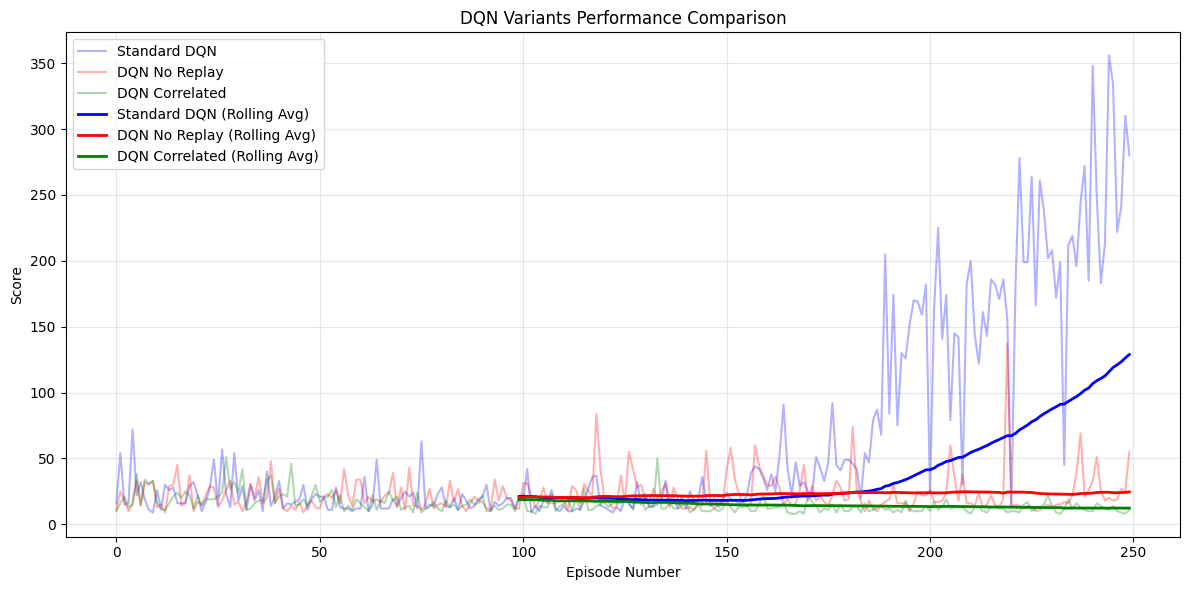

In [29]:
# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Plot raw scores
scores_standard_series.plot(ax=ax, label="Standard DQN", alpha=0.3, color='blue')
scores_no_replay_series.plot(ax=ax, label="DQN No Replay", alpha=0.3, color='red')
scores_correlated_series.plot(ax=ax, label="DQN Correlated", alpha=0.3, color='green')

# Plot rolling averages
scores_standard_series.rolling(window=100).mean().plot(ax=ax, label="Standard DQN (Rolling Avg)", color='blue', linewidth=2)
scores_no_replay_series.rolling(window=100).mean().plot(ax=ax, label="DQN No Replay (Rolling Avg)", color='red', linewidth=2)
scores_correlated_series.rolling(window=100).mean().plot(ax=ax, label="DQN Correlated (Rolling Avg)", color='green', linewidth=2)

ax.legend()
ax.set_xlabel("Episode Number")
ax.set_ylabel("Score")
ax.set_title("DQN Variants Performance Comparison")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

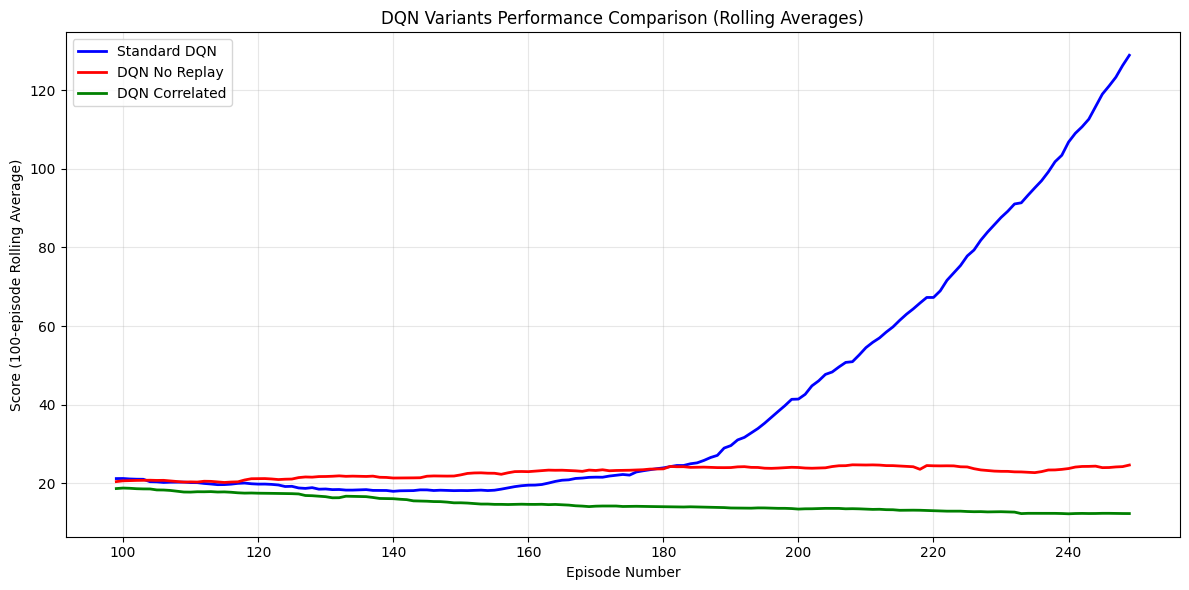

In [30]:
#comparison plot for rolling averages only
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
scores_standard_series.rolling(window=100).mean().plot(ax=ax2, label="Standard DQN", color='blue', linewidth=2)
scores_no_replay_series.rolling(window=100).mean().plot(ax=ax2, label="DQN No Replay", color='red', linewidth=2)
scores_correlated_series.rolling(window=100).mean().plot(ax=ax2, label="DQN Correlated", color='green', linewidth=2)

ax2.legend()
ax2.set_xlabel("Episode Number")
ax2.set_ylabel("Score (100-episode Rolling Average)")
ax2.set_title("DQN Variants Performance Comparison (Rolling Averages)")
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()